Starting training with Approach 2: Path-to-Value Regression...
Iter 0001 │ Policy Loss: 0.0046 │ Regressor MSE: 1.138529 │ Δ=1.1004 │ L2=1.0707
Iter 0100 │ Policy Loss: 0.0045 │ Regressor MSE: 0.007666 │ Δ=0.4733 │ L2=0.0918
Iter 0200 │ Policy Loss: 0.0041 │ Regressor MSE: 0.000798 │ Δ=0.2392 │ L2=0.0263
Iter 0300 │ Policy Loss: 0.0023 │ Regressor MSE: 0.000397 │ Δ=0.1451 │ L2=0.0186
Iter 0400 │ Policy Loss: 0.0026 │ Regressor MSE: 0.000269 │ Δ=0.1050 │ L2=0.0148
Iter 0500 │ Policy Loss: 0.0021 │ Regressor MSE: 0.000155 │ Δ=0.0606 │ L2=0.0119
Iter 0600 │ Policy Loss: 0.0011 │ Regressor MSE: 0.000139 │ Δ=0.1471 │ L2=0.0117
Iter 0700 │ Policy Loss: 0.0009 │ Regressor MSE: 0.000084 │ Δ=0.0616 │ L2=0.0094
Iter 0800 │ Policy Loss: 0.0002 │ Regressor MSE: 0.000071 │ Δ=0.0528 │ L2=0.0086
Iter 0900 │ Policy Loss: -0.0004 │ Regressor MSE: 0.000061 │ Δ=0.0907 │ L2=0.0081
Iter 1000 │ Policy Loss: -0.0006 │ Regressor MSE: 0.000059 │ Δ=0.0358 │ L2=0.0075
Training finished.


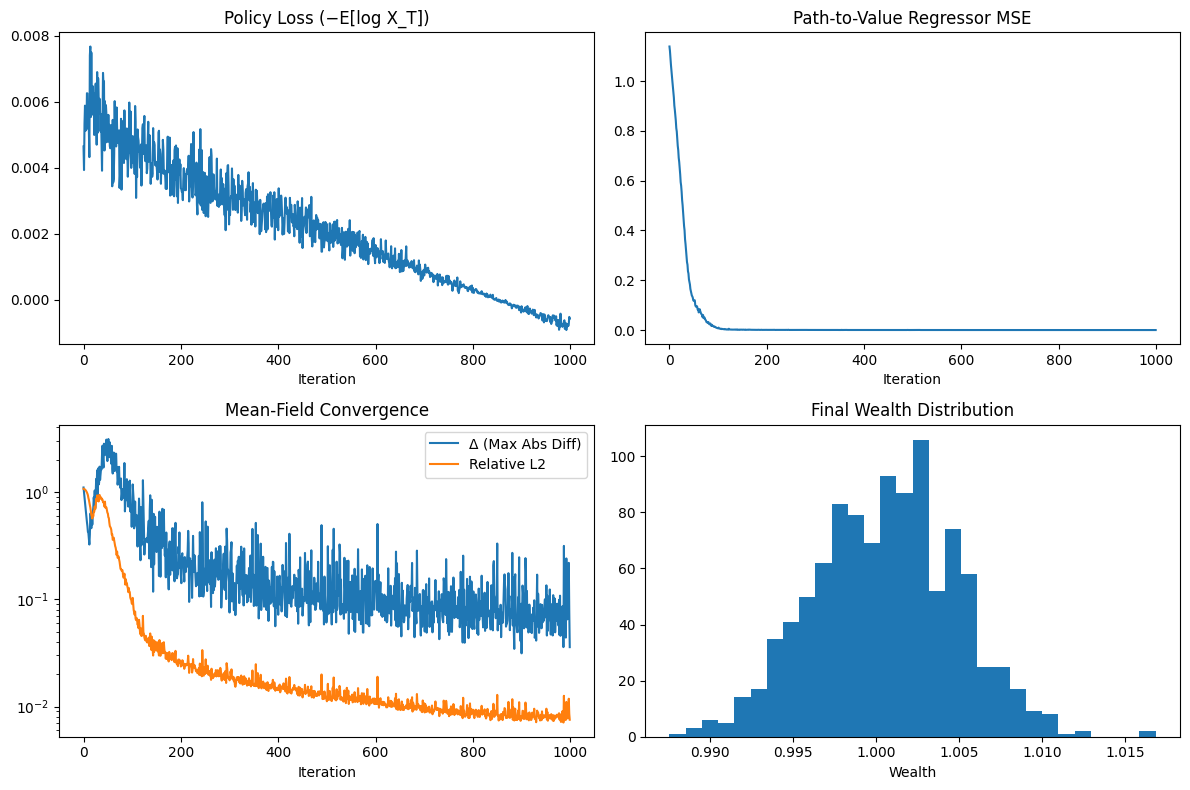

: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import signatory
import matplotlib.pyplot as plt

# === Hyper-parameters ===
T, K = 1.0, 100
dt      = T/K
N       = 1024  # Using a larger batch size for stability
M       = 2     # Signature depth
mu, nu, sigma = 0.05, 0.2, 0.15
X0      = 1.0
ROUNDS  = 1000
MF_ALPHA = 0.1 # Smoothing factor for the mean-field update

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Time grid: [N x (K+1) x 1]
time_grid = torch.linspace(0, T, K+1).unsqueeze(0).unsqueeze(2).repeat(N,1,1).to(device)

def utility(x):
    return torch.log(x + 1e-8)

def rel_L2(curr, prev, dt):
    num = np.mean(np.sum((curr - prev)**2, axis=1) * dt)
    den = np.mean(np.sum(prev**2, axis=1) * dt)
    return np.sqrt(num / (den + 1e-9))

# ── Policy network ────────────────────────────────
def make_policy():
    return nn.Sequential(
        nn.Linear(3, 32), nn.ReLU(),
        nn.Linear(32, 32), nn.ReLU(),
        nn.Linear(32, 32), nn.ReLU(),
        nn.Linear(32, 1)
    ).to(device)

# ── Path-to-Value Regressor (Approach 2) ───────────
class PathToValueRegressor(nn.Module):
    def __init__(self, sig_dim, hidden_dim=32):
        super().__init__()
        # This network learns a direct map from signature to expected value
        self.net = nn.Sequential(
            nn.Linear(sig_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, sigs):
        # Input sigs: [N, sig_dim]
        # Output: [N, 1]
        return self.net(sigs)

# ── One forward simulation ────────────────────────
def simulate(policy, mean_field, dW, dB):
    B = torch.cumsum(dB, dim=1)
    path = torch.cat([time_grid[:, :-1], B], dim=2)
    sig = signatory.signature(path, depth=M)
    
    X = torch.zeros(N, K+1, 1, device=device)
    X[:, 0, 0] = X0
    
    for k in range(K):
        t = time_grid[:, k]; x = X[:, k]; m = mean_field[:, k]
        pi = policy(torch.cat([t, x, m], 1))
        dX = pi * (mu * dt + nu * dW[:, k] + sigma * dB[:, k])
        X[:, k+1] = x + dX
        
    return X, sig

# ── Build models & optimizers ─────────────────────
policy = make_policy()
optP   = torch.optim.Adam(policy.parameters(), lr=1e-5) # Use a small learning rate for stability

sig_dim = signatory.signature_channels(2, M)
# This regressor implements Approach 2
regressor = PathToValueRegressor(sig_dim).to(device)
optR      = torch.optim.Adam(regressor.parameters(), lr=1e-3)

# ── Initialize mean field, histories ─────────────
mf = torch.full((N, K+1, 1), X0, device=device)
histP, histR, histD, histL2 = [], [], [], []

print("Starting training with Approach 2: Path-to-Value Regression...")
for it in range(1, ROUNDS+1):
    dW = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    dB = torch.randn(N, K, 1, device=device) * np.sqrt(dt)
    old_mean = mf.detach().cpu().squeeze(-1).numpy()

    # ── Regressor Training (Approach 2) ──────────────
    # We train the 'regressor' network to approximate E[X_T | F_T^B]
    
    # Simulate to get target wealths and signatures. No gradients needed for policy here.
    with torch.no_grad():
        X1, sig1 = simulate(policy, mf, dW, dB)
        X1_T = X1[:, -1, 0] # Target final wealth [N]
    
    # Get predictions from the regressor
    preds = regressor(sig1) # Output shape: [N, 1]
    
    # Regressor loss (MSE) and optimization step
    lossR = nn.MSELoss()(preds.squeeze(), X1_T)
    optR.zero_grad()
    lossR.backward()
    optR.step()

    # ── Update mean field ───────────────────────────
    # Detach the predictions from the regressor's computation graph
    new_mean_detached = preds.view(N, 1, 1).expand(-1, K + 1, -1).detach()
    
    Δ = (mf - new_mean_detached).abs().max().item()
    cur = new_mean_detached.cpu().squeeze(-1).numpy()
    L2 = rel_L2(cur, old_mean, dt)

    # Apply fictitious play smoothing
    mf = (1 - MF_ALPHA) * mf + MF_ALPHA * new_mean_detached

    # ── Policy training ─────────────────────────────
    # Run a fresh forward pass with the updated mean field to train the policy
    X2, _ = simulate(policy, mf, dW, dB)
    X2_T = X2[:, -1, 0]
    
    lossP = -utility(X2_T).mean()
    optP.zero_grad()
    lossP.backward()
    optP.step()

    # ── Logging ─────────────────────────────────────
    histP.append(lossP.item())
    histR.append(lossR.item())
    histD.append(Δ)
    histL2.append(L2)
    if it % 100 == 0 or it == 1:
      print(f"Iter {it:04d} │ Policy Loss: {lossP:.4f} │ Regressor MSE: {lossR:.6f} │ Δ={Δ:.4f} │ L2={L2:.4f}")

print("Training finished.")
# ── Final visualization ───────────────────────────
plt.figure(figsize=(12, 8))
plt.subplot(221); plt.plot(histP); plt.title("Policy Loss (−E[log X_T])"); plt.xlabel("Iteration")
plt.subplot(222); plt.plot(histR); plt.title("Path-to-Value Regressor MSE"); plt.xlabel("Iteration")
plt.subplot(223)
plt.plot(histD, label='Δ (Max Abs Diff)')
plt.plot(histL2, label='Relative L2')
plt.legend(); plt.title("Mean-Field Convergence"); plt.xlabel("Iteration"); plt.yscale("log")
plt.subplot(224)
plt.hist(X2[:, -1, 0].detach().cpu().numpy(), bins=30, density=True)
plt.title("Final Wealth Distribution"); plt.xlabel("Wealth")
plt.tight_layout()
plt.savefig("output_base.png", dpi=150)   # this writes real PNG data!

plt.show()